<a href="https://colab.research.google.com/github/RIZKYANGKATA/MACHLEARN/blob/main/Modul_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Rizky Angkata Putra S.

Kelas : TI-3A

No. Absen : 24  

PRAKTIKUM P10

PRAKTIKUM 1

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipelin

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'In spite of sterling work by the supporting actors, and an intelligent script by Alan Plater, this film suffers from a fatal flaw - the lack of charm of the central character/actor. One of the characters describes Richard E Grant\'s character as "a whining little turd" and unfortunately this sums him up perfectly. There is nothing about him or his performance to make it credible that his girlfriend and upper-class publisher/friend would spend so much time and emotional effort on him. He is rude, arrogant, selfish, self-destructive and thoroughly annoying. The part called for an actor who can make you love him even when he is being a prate - a Ewan McGregor, for example.<br /><br />All of the witty satire on the class system etc was wasted, thanks to this irritating and thoroughly unlikeable performance. All I wanted to do was shake him and tell him to get over himself.'
 b'Absolutely awful movie. Utter waste of time.<br /><br />background music is so loud that you cannot und

Buat texs encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8,   1,   5, ...,   0,   0,   0],
       [412, 381,  18, ...,   0,   0,   0],
       [  4, 610, 758, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'In spite of sterling work by the supporting actors, and an intelligent script by Alan Plater, this film suffers from a fatal flaw - the lack of charm of the central character/actor. One of the characters describes Richard E Grant\'s character as "a whining little turd" and unfortunately this sums him up perfectly. There is nothing about him or his performance to make it credible that his girlfriend and upper-class publisher/friend would spend so much time and emotional effort on him. He is rude, arrogant, selfish, self-destructive and thoroughly annoying. The part called for an actor who can make you love him even when he is being a prate - a Ewan McGregor, for example.<br /><br />All of the witty satire on the class system etc was wasted, thanks to this irritating and thoroughly unlikeable performance. All I wanted to do was shake him and tell him to get over himself.'
Round-trip:  in [UNK] of [UNK] work by the supporting actors and an [UNK] script by [UNK] [UNK] this fil

buat model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00337225]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00337225]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

train model

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 101ms/step - loss: 0.6452 - accuracy: 0.5622 - val_loss: 0.4684 - val_accuracy: 0.7823
Epoch 2/10
391/391 [==============================] - 28s 72ms/step - loss: 0.4213 - accuracy: 0.8000 - val_loss: 0.3846 - val_accuracy: 0.8182
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3522 - accuracy: 0.8460 - val_loss: 0.3537 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3279 - accuracy: 0.8563 - val_loss: 0.3362 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3141 - accuracy: 0.8634 - val_loss: 0.3522 - val_accuracy: 0.8286
Epoch 6/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3107 - accuracy: 0.8667 - val_loss: 0.3270 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3026 - accuracy: 0.8710 - val_loss: 0.3348 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3151 - accuracy: 0.8575
Test Loss: 0.3150927722454071
Test Accuracy: 0.857479989528656


(0.0, 0.6625684142112732)

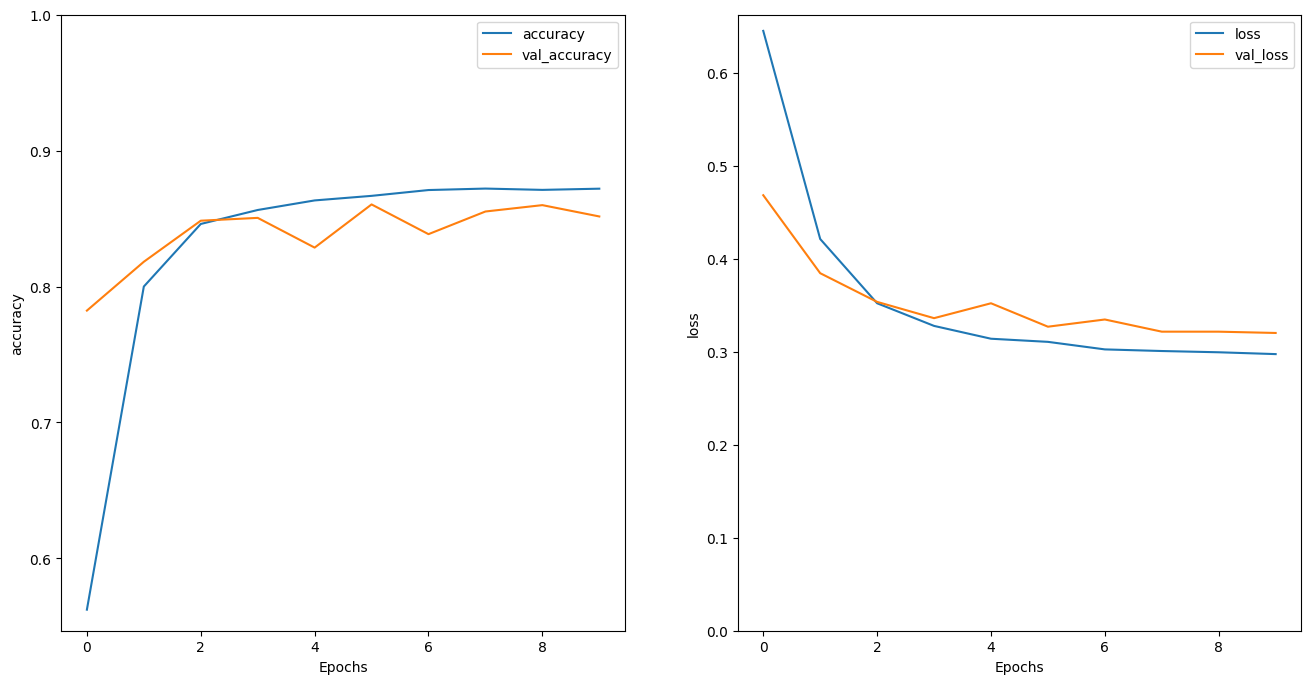

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics ''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
 validation_data=test_dataset,
 validation_steps=30)

Epoch 1/10
391/391 [==============================] - 82s 159ms/step - loss: 0.6338 - accuracy: 0.5771 - val_loss: 0.4802 - val_accuracy: 0.7333
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3914 - accuracy: 0.8280 - val_loss: 0.3721 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3442 - accuracy: 0.8518 - val_loss: 0.3428 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3199 - accuracy: 0.8637 - val_loss: 0.3332 - val_accuracy: 0.8432
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3147 - accuracy: 0.8660 - val_loss: 0.3204 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3039 - accuracy: 0.8698 - val_loss: 0.3178 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3011 - accuracy: 0.8720 - val_loss: 0.3166 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3150 - accuracy: 0.8606
Test Loss: 0.31500980257987976
Test Accuracy: 0.8605999946594238


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ''were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.6955893]]


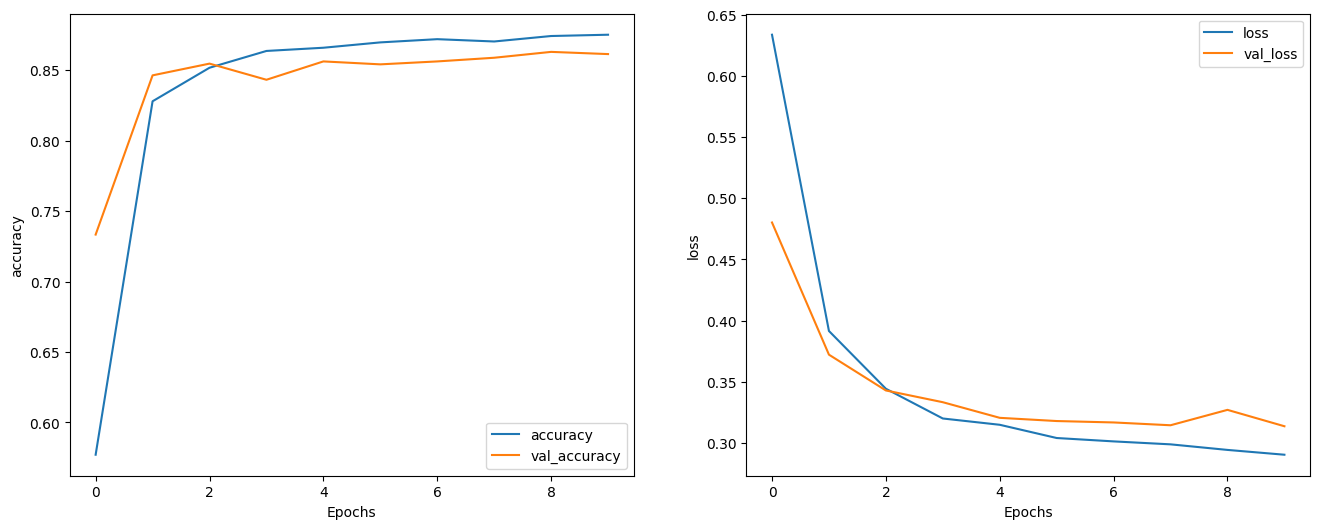

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

PRAKTIKUM 2

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

download dataset shakespeare

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


olah teks

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding ='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

prediksi

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


membuat batch training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

buat model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

uji model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([46, 36, 15, 30, 54,  0, 20, 25, 27,  7, 32, 17, 65, 31, 10, 42,  1,
       23, 37, 51, 50,  9,  9, 55,  4, 47, 48, 42, 25, 38, 23, 10, 51, 33,
        7, 36,  7, 29, 35, 17, 63, 22, 18, 38, 28,  8, 59, 56,  3, 16, 57,
       54, 25, 47, 60, 55, 15, 25, 47, 39,  7, 50,  1, 46,  4, 46, 64, 65,
       48, 58, 26, 58,  4, 14, 18, 40, 65,  9, 54, 49, 57, 50, 37, 12, 19,
       13, 45, 26, 35, 21, 20, 55,  9, 42, 55, 48, 21, 37, 59, 64])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' is so fond\nTo trust the mockery of unquiet slumbers\nTo fly the boar before the boar pursues,\nWere t'

Next Char Predictions:
 b'gWBQo[UNK]GLN,SDzR3c\nJXlk..p$hicLYJ3lT,W,PVDxIEYO-tq!CroLhupBLhZ,k\ng$gyzisMs$AEaz.ojrkX;F?fMVHGp.cpiHXty'


train model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1905675, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.06027

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 54ms/step - loss: 2.7050
Epoch 2/20
172/172 [==============================] - 11s 53ms/step - loss: 1.9881
Epoch 3/20
172/172 [==============================] - 11s 53ms/step - loss: 1.7057
Epoch 4/20
172/172 [==============================] - 11s 53ms/step - loss: 1.5442
Epoch 5/20
172/172 [==============================] - 11s 53ms/step - loss: 1.4461
Epoch 6/20
172/172 [==============================] - 12s 54ms/step - loss: 1.3788
Epoch 7/20
172/172 [==============================] - 12s 54ms/step - loss: 1.3265
Epoch 8/20
172/172 [==============================] - 11s 54ms/step - loss: 1.2819
Epoch 9/20
172/172 [==============================] - 11s 54ms/step - loss: 1.2409
Epoch 10/20
172/172 [==============================] - 11s 55ms/step - loss: 1.2014
Epoch 11/20
172/172 [==============================] - 11s 56ms/step - loss: 1.1617
Epoch 12/20
172/172 [==============================] - 11s 55ms/step - loss: 1.1202
E

generate teks

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
My lord, what neither has but join'd to do
He tears the envy way of thy news?
Where's Birdone Vincentio and his less?

DUCHESS OF YORK:
No, you and yours are foolish in our marchers,
That burn better, sir: I say.

GLOUCESTER:
Thou fart'st of fairs, sir, by my soul I shall not;
A cegtats or else dead like a due as little
Gloucester, think o' the people, when he makes forsworn,
You, titles, the people see my grief in pomp,
Ere furnish'd hath the proclamation of thy brother:
Varcius, we'll in one that effect the proves me
all perish.

First Lord:
Sir, at the lovely king, and fit you
Shall she beggar her love, from it, that they under-the men;
Ahou, Venical, are already of each impediment:
With this amounds the invettitute
That water to a look and thanks, and rans
To roy approbation.

Messenger:
Ay, therefore thy lapt our knees to use it,
Whereso understand that he drezs in thy son
Could yet sub-bush and Romeo play?

PETRUCHIO:
I am bound ere not you a mad at your request,
And his a

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nMy lord, Meaning the hearing of your buddiness!\nOf, dear, my gracious lord, here look this isle, no futcher of a sun\nCan all their own particular thright on his.\n\nJULIET:\nAy, to conceal your pleasure thou art a footman.\n\nLADY ANNE:\nBut shall I not? Shall have the crown?\n\nSICINIUS:\nSon you your honour'd house,\nBesides the sound of noble place hath made\nFor-zenture to begone a great natural age,\nwhom you can with the flow's an quicks of souls?\n\nNurse:\nMy business; we will ask.\n\nESCALUS:\nI shall report your grace is here.\n\nGRUMIO:\nI not look for.\nI cannot speak, for that your gifts are so\nOf noble queen and cries 'Romeo's home; and here with the king; and\n'Clarence, stand up, the Duke of Norfolk:\nShortly Warwick springs them both; I do beseech the people\nThey will from thence the rest should be bold.\n\nBAPTISTA:\nHow accords ne traitor?\n\nCLAMENCE:\nOur dead? why, 'Why now?\n\nThird Servingman:\nWhere is your good use.\n\nFirst Lord:\nBe

ekspor model generator

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
So long as Davouried it would pluck thee one
That boar it shrield and fear o' the same, or let us s


TUGAS PRAKTIKUM

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 18s 52ms/step - loss: 2.7042


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

      # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))


        print()
        print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
        print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
        print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1762
Epoch 1 Batch 50 Loss 2.0232
Epoch 1 Batch 100 Loss 1.9017
Epoch 1 Batch 150 Loss 1.8061
Epoch 2 Batch 0 Loss 1.7894
Epoch 2 Batch 50 Loss 1.7170
Epoch 2 Batch 100 Loss 1.6670
Epoch 2 Batch 150 Loss 1.6272
Epoch 3 Batch 0 Loss 1.6324
Epoch 3 Batch 50 Loss 1.5366
Epoch 3 Batch 100 Loss 1.4929
Epoch 3 Batch 150 Loss 1.5541
Epoch 4 Batch 0 Loss 1.4513
Epoch 4 Batch 50 Loss 1.4278
Epoch 4 Batch 100 Loss 1.4344
Epoch 4 Batch 150 Loss 1.3865
Epoch 5 Batch 0 Loss 1.3938

Epoch 5 Loss: 1.3938
Time taken for 1 epoch 2.59 sec
________________________________________________________________________________
Epoch 5 Batch 50 Loss 1.3895

Epoch 5 Loss: 1.3870
Time taken for 1 epoch 5.29 sec
________________________________________________________________________________
Epoch 5 Batch 100 Loss 1.3368

Epoch 5 Loss: 1.3835
Time taken for 1 epoch 7.97 sec
________________________________________________________________________________
Epoch 5 Batch 150 Loss 1.3704

Epoch 5 L